In [3]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [4]:
nop.plot_setup()

In [5]:
# Define util functions


def get_name(N, nn, sd_llf, run, actInf=1):
    name = (
        "../testing/@MA5-fep/output_tmp/out"
        + "-N"
        + str(N)
        + "-nn"
        + str(nn)
        + "actInf"
        + str(actInf)
        + "-sd_llf"
        + str(sd_llf)
        + "-run"
        + str(run)
        + ".h5"
    )
    return name


def get_mu(N, nn, sd_llf, run):
    data = nop.import_hdf5(get_name(N, nn, sd_llf, run), samples=True)
    return data["mu_nodes"]


def get_sd(N, nn, sd_llf, run):
    data = nop.import_hdf5(get_name(N, nn, sd_llf, run), samples=True)
    return data["sd_nodes"]


def get_kld(N, nn, sd_llf, run):
    data = nop.import_hdf5(get_name(N, nn, sd_llf, run), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs


def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / (2 * sd2**2) - 1 / 2


def get_ls(sd_llf):
    ls = ""
    if sd_llf == 1:
        ls = "--"
    elif sd_llf < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [6]:
# Define parameter ranges to be used in this analysis
N_nodes = 150
N_arr = [1, 2, 150]
nn_arr = np.concatenate((np.arange(2), np.arange(3.0, 15.1, 3.0)), dtype="float")
sd_llf_arr = np.round(np.arange(0.5, 3.1, 0.5), 1)
t_arr = np.arange(1e4 + 1)
t2_len = 1001
run_arr = np.arange(7)

In [7]:
# Initialize xarray Dataset
tmp_arr = np.empty(
    (
        len(N_arr),
        len(nn_arr),
        len(sd_llf_arr),
        len(t_arr),
        len(run_arr),
        N_nodes,
    )
)
ds = xr.Dataset(
    {
        "mu": (
            ("N", "nn", "sd_llf", "time", "run", "node"),
            np.empty_like(tmp_arr),
        ),
        "sd": (
            ("N", "nn", "sd_llf", "time", "run", "node"),
            np.empty_like(tmp_arr),
        ),
        "kld": (
            ("N", "nn", "sd_llf", "time", "run", "node"),
            np.empty_like(tmp_arr),
        ),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "run": run_arr,
        "time": t_arr,
        "node": np.arange(N_nodes),
    },
)
del tmp_arr

# Populate the Dataset
for N, sd_llf in itertools.product(N_arr, sd_llf_arr):
    if N == 1:
        nn = 0
        ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, run=0, node=np.arange(N_nodes))] = (
            get_mu(N, nn, sd_llf, run=0)
        )
        ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, run=0, node=np.arange(N_nodes))] = (
            get_sd(N, nn, sd_llf, run=0)
        )
        ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, run=0, node=np.arange(N_nodes))] = (
            get_kld(N, nn, sd_llf, run=0)
        )
    elif N == 2:
        nn = 1
        ds.mu.loc[
            dict(
                N=N,
                nn=nn,
                sd_llf=sd_llf,
                run=0,
                node=np.arange(N_nodes),
                time=t_arr[:t2_len],
            )
        ] = get_mu(N, nn, sd_llf, run=0)
        ds.sd.loc[
            dict(
                N=N,
                nn=nn,
                sd_llf=sd_llf,
                run=0,
                node=np.arange(N_nodes),
                time=t_arr[:t2_len],
            )
        ] = get_sd(N, nn, sd_llf, run=0)
        ds.kld.loc[
            dict(
                N=N,
                nn=nn,
                sd_llf=sd_llf,
                run=0,
                node=np.arange(N_nodes),
                time=t_arr[:t2_len],
            )
        ] = get_kld(N, nn, sd_llf, run=0)
    else:
        for run, nn in itertools.product(run_arr, nn_arr[2:]):
            ds.mu.loc[
                dict(
                    N=N,
                    nn=nn,
                    sd_llf=sd_llf,
                    run=run,
                    node=np.arange(N_nodes),
                    time=t_arr[:t2_len],
                )
            ] = get_mu(N, nn, sd_llf, run)
            ds.sd.loc[
                dict(
                    N=N,
                    nn=nn,
                    sd_llf=sd_llf,
                    run=run,
                    node=np.arange(N_nodes),
                    time=t_arr[:t2_len],
                )
            ] = get_sd(N, nn, sd_llf, run)
            ds.kld.loc[
                dict(
                    N=N,
                    nn=nn,
                    sd_llf=sd_llf,
                    run=run,
                    node=np.arange(N_nodes),
                    time=t_arr[:t2_len],
                )
            ] = get_kld(N, nn, sd_llf, run)
ds

<xarray.Dataset> Size: 32GB
Dimensions:  (N: 3, nn: 7, sd_llf: 6, time: 10001, run: 7, node: 150)
Coordinates:
  * N        (N) int64 24B 1 2 150
  * nn       (nn) float64 56B 0.0 1.0 3.0 6.0 9.0 12.0 15.0
  * sd_llf   (sd_llf) float64 48B 0.5 1.0 1.5 2.0 2.5 3.0
  * run      (run) int64 56B 0 1 2 3 4 5 6
  * time     (time) float64 80kB 0.0 1.0 2.0 3.0 ... 9.998e+03 9.999e+03 1e+04
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, run, node) float64 11GB 0.0 0.0 ... 0.0 0.0
    sd       (N, nn, sd_llf, time, run, node) float64 11GB 10.01 10.01 ... 0.0
    kld      (N, nn, sd_llf, time, run, node) float64 11GB 1.809 1.809 ... 0.0

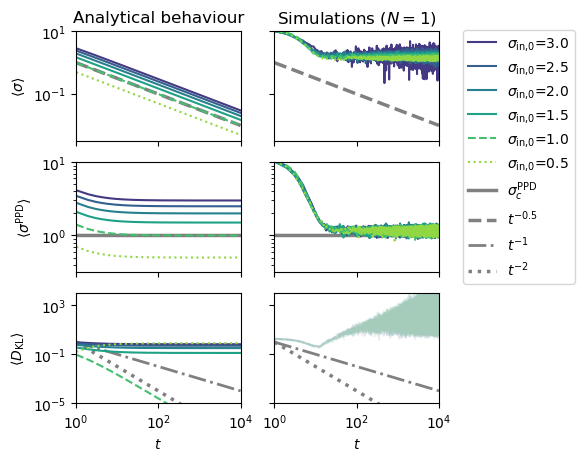

In [8]:
# Analysis vs. N=1
sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
time = ds.time.values
x = 2
y = 3
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i, j in itertools.product(np.arange(y), np.arange(x)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
label05 = "$t^{-0.5}$"
label0 = "$\sigma^\\text{PPD}_{c}$"
label1 = "$t^{-1}$"
label2 = ("$t^{-2}$",)
for j in range(x):
    (line0,) = ax[1, j].plot(
        time[1:],
        np.ones(len(time[1:])) * sd_C,
        color="grey",
        lw=2.5,
        label=label0,
    )
    (line05,) = ax[0, j].plot(
        time[1:],
        time[1:] ** -0.5,
        color="grey",
        ls="--",
        lw=2.5,
        label=label05,
    )
    (line2,) = ax[2, j].plot(
        time[1:],
        time[1:] ** -2,
        color="grey",
        ls=":",
        lw=2.5,
        label=label2,
    )
    (line1,) = ax[2, j].plot(
        time[1:],
        time[1:] ** -1,
        color="grey",
        ls="-.",
        lw=2,
        label=label1,
    )

# Plot analytical results...
j = 0
lines = []
for sd_in in sd_arr:
    # sd_N(N)
    sd = sd_N(sd0, sd_in, time)
    ax[0, j].plot(
        time,
        sd,
        ls=get_ls(sd_in),
    )
    ax[0, j].set_ylabel("$\langle\sigma\\rangle$")
    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1, j].plot(
        time,
        sd_PPD,
        ls=get_ls(sd_in),
    )
    ax[1, j].set_ylabel("$\langle \sigma^\\text{PPD} \\rangle$")
    # KLD_PPD(N), given same means and sd_P=1
    (line_tmp,) = ax[2, j].plot(
        time,
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_\\text{in,0}$=" + str(sd_in),
    )
    lines.append(line_tmp)
    ax[2, j].set_ylabel("$\langle D_\\text{KL} \\rangle$")

# Data plots
# N=1, nn=0
j = 1
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].plot(
        time,
        (
            (
                ds.sd.sel(
                    N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
                )
                ** 2
                - sd_llf**2
            )
            ** 0.5
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time,
        ds.sd.sel(
            N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].plot(
        time,
        ds.kld.sel(
            N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
        ).mean(dim="node"),
        alpha=0.1,
        ls=get_ls(sd_llf),
    )

# Labelling & stuffs...
for j in range(x):
    ax[0, j].set_ylim(10**-2.5, 10**1)
    ax[0, j].xaxis.set_tick_params(labelbottom=False)
    ax[1, j].set_ylim(10**-0.5, 10**1)
    ax[1, j].xaxis.set_tick_params(labelbottom=False)
    ax[2, j].set_ylim(10**-5, 10**4)
    ax[y - 1, j].set_xlabel("$t$")
for i in range(y):
    ax[i, 1].yaxis.set_tick_params(labelleft=False)

# Analytical
j = 0
ax[0, j].set_title("Analytical behaviour")
# Simulation N=1
j = 1
ax[0, j].set_title("Simulations $(N=1)$")

fig.legend(
    handles=lines + [line0, line05, line1, line2],
    bbox_to_anchor=(1, 0.96),
    loc=2,
)

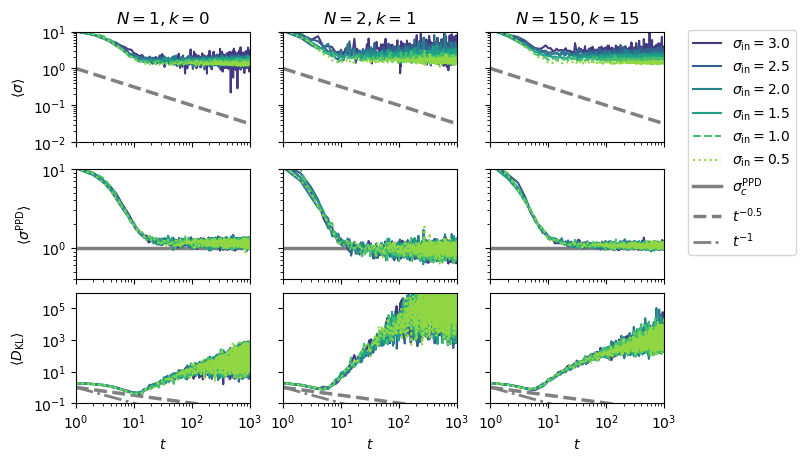

In [9]:
# N=1,2,150
sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
time = ds.time.values
t2_len = len(get_kld(2, 1, sd_llf_arr[-1], run=0))
time = time[:t2_len]
run_arr = np.arange(7)
# Figure set-up...
x = 3
y = 3
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i, j in itertools.product(np.arange(y), np.arange(x)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
label05 = "$t^{-0.5}$"
label0 = "$\sigma^\\text{PPD}_{c}$"
label1 = "$t^{-1}$"
for j in range(x):
    (line0,) = ax[1, j].plot(
        time[1:],
        np.ones(t2_len - 1) * sd_C,
        color="grey",
        ls="-",
        lw=2.5,
        label=label0,
    )
    (line05,) = ax[0, j].plot(
        time[1:],
        time[1:] ** -0.5,
        color="grey",
        ls="--",
        lw=2.5,
        label=label05,
    )
    (line1,) = ax[2, j].plot(
        time[1:],
        time[1:] ** -1,
        color="grey",
        ls="-.",
        lw=2,
        label=label1,
    )
    ax[2, j].plot(
        time[1:],
        time[1:] ** -0.5,
        lw=2.5,
        color="grey",
        ls="--",
        label=label05,
    )

# Data plots
# N=1, nn=0
j = 0
lines = []
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].set_ylabel("$\langle\sigma\\rangle$")
    (line_tmp,) = ax[i, j].plot(
        time,
        (
            (
                ds.sd.sel(
                    N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
                )
                ** 2
                - sd_llf**2
            )
            ** 0.5
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
        label="$\sigma_\\text{in}=$" + str(sd_llf),
    )
    lines.append(line_tmp)
    # <sd^PPD_i>
    i = 1
    ax[i, j].set_ylabel("$\langle \sigma^\\text{PPD} \\rangle$")
    ax[i, j].plot(
        time,
        ds.sd.sel(
            N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].set_ylabel("$\langle D_\\text{KL} \\rangle$")
    ax[i, j].plot(
        time,
        ds.kld.sel(
            N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
# N=2, nn=1
j = 1
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].plot(
        time[:t2_len],
        (
            (
                ds.sd.sel(
                    N=2,
                    nn=1,
                    sd_llf=sd_llf,
                    time=time[:t2_len],
                    node=np.arange(N_nodes),
                )
                ** 2
                - sd_llf**2
            )
            ** 0.5
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time[:t2_len],
        ds.sd.sel(
            N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <KLD_i>
    i = 2
    ax[i, j].plot(
        time[:t2_len],
        ds.kld.sel(
            N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
# N=150, k= <some nn>
j = 2
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    nn = 3
    ax[i, j].plot(
        time[:t2_len],
        (
            (
                ds.sd.sel(
                    N=150,
                    nn=nn,
                    sd_llf=sd_llf,
                    time=time[:t2_len],
                    node=np.arange(N_nodes),
                )
                ** 2
                - sd_llf**2
            )
            ** 0.5
        )
        .mean(dim="node")
        .mean(dim="run"),
        label="",
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time[:t2_len],
        ds.sd.sel(
            N=150,
            nn=nn,
            sd_llf=sd_llf,
            run=run_arr,
            time=time[:t2_len],
            node=np.arange(N_nodes),
        )
        .mean(dim="node")
        .mean(dim="run"),
        label="",
        ls=get_ls(sd_llf),
    )
    # <KLD_i>
    i = 2
    ax[i, j].plot(
        time[:t2_len],
        ds.kld.sel(
            N=150, nn=nn, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        )
        .mean(dim="node")
        .mean(dim="run"),
        label="",
        ls=get_ls(sd_llf),
    )

# Labelling & stuffs...
j = 0
ax[0, j].set_title("$N=1, k=0$")
j = 1
ax[0, j].set_title("$N=2, k=1$")
j = 2
ax[0, j].set_title("$N=150, k=15$")
for j in range(x):
    ax[0, j].set_ylim(10**-2, 10**1)
    ax[1, j].set_ylim(10**-0.4, 10**1)
    ax[2, j].set_ylim(10**-1, 10**6)
    ax[y - 1, j].set_xlabel("$t$")
    ax[0, j].xaxis.set_tick_params(labelbottom=False)
    ax[1, j].xaxis.set_tick_params(labelbottom=False)
    if j != 0:
        for i in range(y):
            ax[i, j].yaxis.set_tick_params(labelleft=False)

fig.legend(
    handles=lines + [line0, line05, line1],
    bbox_to_anchor=(1, 0.96),
    loc=2,
)

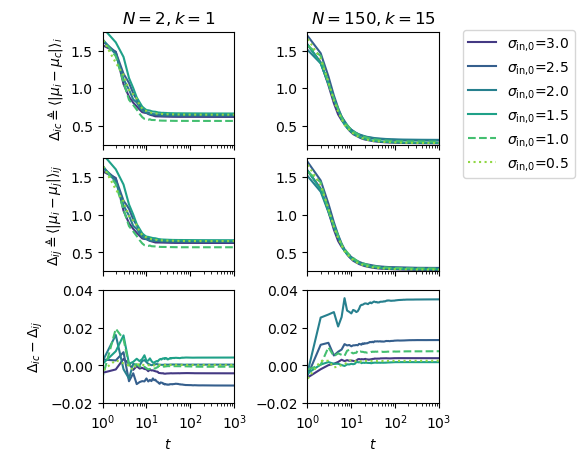

In [13]:
# <|mu_i-mu_c|>
# Figure set-up
x, y = (2, 3)
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))


# Params of interest
N_nodes = 150
N_arr = [2, 150]
nn_arr = np.concatenate((np.arange(2), np.arange(3.0, 15.1, 3.0)), dtype="float")
run_arr = np.arange(7)
sd_arr = ds.sd_llf.values[::-1]
time = ds.time.values
t2_len = len(get_kld(2, 1, sd_llf_arr[-1], run=0))
time = time[:t2_len]

# Plot prep.
for i in ax.reshape(-1):
    i.set_xscale("log")
    # i.set_yscale("log")
    i.set_prop_cycle(color=colors)
    i.set_xlim((time[1], time[-1]))
    # i.set_ylim(0, 2)

lines = []
# Plotting...
for sd_llf in sd_arr:
    # N=2
    j = 0
    ds_tmp = ds.sel(
        N=2,
        nn=1,
        sd_llf=sd_llf,
        run=0,
        time=time,
        node=np.arange(N_nodes),
    )
    # <|mu_i-mu_C|>
    i = 0
    ax[i, j].plot(
        time,
        np.abs(ds_tmp.mu).mean(dim="node"),
        ls=get_ls(sd_llf),
        label="$_\sigma_\\text{in,0}$=" + str(sd_llf),
    )
    # <|mu_i-mu_G|>
    i = 1
    ax[i, j].plot(
        time,
        np.abs(ds_tmp.mu - ds_tmp.mu.mean(dim="node")).mean(dim="node"),
        ls=get_ls(sd_llf),
        label="$_\sigma_\\text{in,0}$=" + str(sd_llf),
    )
    # <|D1-D2|>
    i = 2
    ax[i, j].plot(
        time,
        (
            np.abs(ds_tmp.mu).mean(dim="node")
            - np.abs(ds_tmp.mu - ds_tmp.mu.mean(dim="node")).mean(dim="node")
        ),
        ls=get_ls(sd_llf),
        label="$_\sigma_\\text{in,0}$=" + str(sd_llf),
    )
    j = 1
    ds_tmp = ds.sel(
        N=150,
        nn=15,
        sd_llf=sd_llf,
        time=time,
        node=np.arange(N_nodes),
    )
    # <|mu_i-mu_C|>
    i = 0
    ax[i, j].plot(
        time,
        np.abs(ds_tmp.mu).mean(dim=["node", "run"]),
        ls=get_ls(sd_llf),
        label="$_\sigma_\\text{in,0}$=" + str(sd_llf),
    )
    # <|mu_i-mu_G|>
    i = 1
    ax[i, j].plot(
        time,
        np.abs(ds_tmp.mu - ds_tmp.mu.mean(dim="node")).mean(dim=["node", "run"]),
        ls=get_ls(sd_llf),
        label="$_\sigma_\\text{in,0}$=" + str(sd_llf),
    )
    # <|D1-D2|>
    i = 2
    (line_tmp,) = ax[i, j].plot(
        time,
        (
            np.abs(ds_tmp.mu).mean(dim=["node", "run"])
            - np.abs(ds_tmp.mu - ds_tmp.mu.mean(dim="node")).mean(dim=["node", "run"])
        ),
        ls=get_ls(sd_llf),
        label="$\sigma_\\text{in,0}$=" + str(sd_llf),
    )
    lines.append(line_tmp)

# Title, label, ...
ax[0, 0].set_title("$N=2, k=1$")
ax[0, 1].set_title("$N=150, k=15$")

for j in np.arange(x):
    ax[0, j].set_ylim(0.25, 1.75)
    ax[1, j].set_ylim(0.25, 1.75)
    ax[2, j].set_ylim(-0.02, 0.04)
    ax[y - 1, j].set_xlabel("$t$")
    for i in np.arange(y - 1):
        ax[i, j].xaxis.set_tick_params(labelbottom=False)

ax[0, 0].set_ylabel("$\Delta_{ic} \\triangleq \langle |\mu_i-\mu_c|\\rangle_i$")
ax[1, 0].set_ylabel("$\Delta_{ij}\\triangleq\langle |\mu_i-\mu_j|\\rangle_{ij}$")
ax[2, 0].set_ylabel("\n$\Delta_{ic} - \Delta_{ij}$")

fig.legend(handles=lines, bbox_to_anchor=(1, 0.96), loc=2)

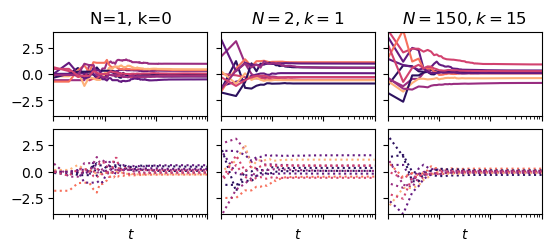

In [42]:
# Figure set-up
x, y = (3, 2)
c = 1.2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr), cmap="magma")

# Params of interest
N_arr = [1, 2, 150]
nn_arr = [0, 1, 15]
sd_arr = ds.sd_llf.values[::-1]
time = ds.time.values
t2_len = len(get_kld(2, 1, sd_llf_arr[-1], run=0))
time = time[:t2_len]
# Plot prep.
for i in ax.reshape(-1):
    i.set_prop_cycle(color=colors)
    i.set_xlim((time[1], time[-1]))
    i.set_ylim(-4, 4)
    i.set_xscale("log")

# Plotting...
for i, sd_llf in enumerate([sd_arr[0], sd_arr[-1]]):
    # <|mu_i-mu_C|>
    for j, N in enumerate(N_arr):
        ax[i, j].plot(
            time,
            ds.mu.sel(
                N=N,
                nn=nn_arr[j],
                sd_llf=sd_llf,
                time=time,
                run=0,
                node=np.arange(0, 150, 5)[:10],
            ),
            ls=get_ls(sd_llf),
            label="$\sigma_\\text{in,0}$=" + str(sd_llf),
        )

# Title, label, ...
ax[0, 0].set_title("N=1, k=0")
ax[0, 1].set_title("$N=2, k=1$")
ax[0, 2].set_title("$N=150, k=15$")
for j in np.arange(x):
    ax[y - 1, j].set_xlabel("$t$")
    ax[0, j].xaxis.set_tick_params(labelbottom=False)
    ax[1, j].xaxis.set_tick_params(labelbottom=False)
    if j != 0:
        for i in range(y):
            ax[i, j].yaxis.set_tick_params(labelleft=False)


# ax[0].set_ylabel("\n$\langle |\mu_i-\mu_c|\\rangle_i$")
# ax[i].legend(bbox_to_anchor=(1.1, 1.06), loc=2)